In [1]:
#install necessary libraries
#Only needed on the first time
#Hash after first time

# !pip install statsmodels
# !pip install datetime
# !pip install matplotlib
# !pip install math
# !pip install sklearn

In [2]:
# Importing Libraries

import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
# Loading CSV and preprocessing data files

peru = pd.read_csv('Country Price/Peru.csv')
mexico = pd.read_csv('Country Price/Mexico.csv')
honduras = pd.read_csv('Country Price/Honduras.csv')
elsalvador = pd.read_csv('Country Price/El Salvador.csv')
columbia = pd.read_csv('Country Price/Columbia.csv')
dominican = pd.read_csv('Country Price/Dominican Republic.csv')

# Getting year and Month
def get_year_month(df):
    df['year'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).year
    df['month'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).month
    return df

peru = get_year_month(peru)
mexico = get_year_month(mexico)
honduras = get_year_month(honduras)
elsalvador = get_year_month(elsalvador)
columbia = get_year_month(columbia)
dominican = get_year_month(dominican)

peru.set_index('Date',inplace = True)
mexico.set_index('Date',inplace = True)
honduras.set_index('Date',inplace = True)
elsalvador.set_index('Date',inplace = True)
columbia.set_index('Date',inplace = True)
dominican.set_index('Date',inplace = True)

### Part 1 - Using only Price Data

In [4]:
# Model Building 1: ARIMA and Moving Averages

import warnings
warnings.filterwarnings('ignore')

# Getting Best ARIMA Using out of Time Cross Validation
def evaluate_arima_model(X, arima_order,timeperiod):
    # prepare training dataset
    train_size = int(len(X) * 0.5)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train[:-timeperiod]]
    # make predictions
    m3_predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        fc, se, conf = model_fit.forecast(12, alpha=0.05)  # 95% conf
        m3_predictions.append(fc[2])
        history.append(test[t])
    
    evaluating_df = pd.DataFrame(test)
    evaluating_df['m3_predictions'] = m3_predictions
    evaluating_df['m3_predictions'] = evaluating_df['m3_predictions'].shift(3)
    evaluating_df.dropna(inplace = True)
    
    # calculate out of sample error    
    error = sqrt(mean_squared_error(evaluating_df['Price USD'], evaluating_df['m3_predictions']))
    r2 = r2_score(evaluating_df['Price USD'], evaluating_df['m3_predictions'])
    return error, m3_predictions, r2

def evaluate_models(df, p_values, d_values, q_values,timeperiod):
    dataset = df['Price USD'].astype('float32')
    best_score, best_cfg = float("inf"), None
    best_prediction = [0 for x in range(int(len(df) * 0.5))]
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse, predictions, r2 = evaluate_arima_model(dataset, order,timeperiod)
                    # keep bottom code to get rmse for all arima model.
                    #print('ARIMA%s RMSE=%.3f' % (order,round(sqrt(rmse),3)))
                    if rmse < best_score:
                        best_score, best_cfg, best_r2 = rmse, order, r2
                        best_prediction = predictions
                except:
                    continue
    print('Best ARIMA %s RMSE=%.3f' % (best_cfg, round(best_score,3) ))   
    print('Best ARIMA R2 is ', best_r2)
    
    # Getting all 12 month forecast
    train_size = int(len(dataset) * 0.5)
    train, test = dataset[0:train_size], dataset[train_size:]
    history = [x for x in train[:-timeperiod]]
    # make predictions
    m3_predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_cfg)
        model_fit = model.fit()
        fc, se, conf = model_fit.forecast(12, alpha=0.05)  # 95% conf
        m3_predictions.append(fc)
        history.append(dataset[t+train_size-timeperiod])
    
    m3_predictions = np.array(m3_predictions).transpose()
    
    df.loc[int(len(df) * 0.5):,'1_month_predict'] = m3_predictions[0]
    df.loc[int(len(df) * 0.5):,'2_month_predict']= m3_predictions[1]
    df.loc[int(len(df) * 0.5):,'3_month_predict']= m3_predictions[2]
    df.loc[int(len(df) * 0.5):,'4_month_predict']= m3_predictions[3]
    df.loc[int(len(df) * 0.5):,'5_month_predict']= m3_predictions[4]
    df.loc[int(len(df) * 0.5):,'6_month_predict']= m3_predictions[5]
    df.loc[int(len(df) * 0.5):,'7_month_predict']= m3_predictions[6]
    df.loc[int(len(df) * 0.5):,'8_month_predict']= m3_predictions[7]
    df.loc[int(len(df) * 0.5):,'9_month_predict']= m3_predictions[8]
    df.loc[int(len(df) * 0.5):,'10_month_predict']= m3_predictions[9]
    df.loc[int(len(df) * 0.5):,'11_month_predict']= m3_predictions[10]
    df.loc[int(len(df) * 0.5):,'12_month_predict']= m3_predictions[11]      
    #df.loc[int(len(df) * 0.5):,'ARIMA Best Predict'] = best_prediction
    print('Predicted Results')
    return best_score, best_cfg


# Comparing ARIMA, Simple and Moving Average.
def comparing_model(df):
    # ARIMA Model Output
    print('Error Using Arima Model', round(rmse,3))
    
    # Predicting with just 3th last month price
    df['Last 3Month Price'] = df['Price USD'].shift(3)
    error_check1 = df[['Last 3Month Price','Price USD']].dropna()
    print('Error by Predicting price using just 3th Last Month Price.', round(sqrt(mean_squared_error(error_check1['Last 3Month Price'], error_check1['Price USD'])),3))

    # Predicting with just 3th, 4th and 5th Month Price
    df['Last 3Month Price'] = df['Price USD'].shift(3)
    df['Last 4Month Price'] = df['Price USD'].shift(4)
    df['Last 5Month Price'] = df['Price USD'].shift(5)
    df['3month avg'] = (df['Last 3Month Price']+df['Last 4Month Price']+df['Last 5Month Price'])/3
    error_check2 = df[['3month avg', 'Price USD']].dropna()
    print('Error by Predicting price using just 3th, 4th, 5th Last Month Price.', round(sqrt(mean_squared_error(error_check2['3month avg'], error_check2['Price USD'])),3))
    
    # Predicting using exponential moving average
    df['exponential average'] = df['Price USD'].ewm(com=0.1).mean().shift(3)
    error_check3 = df[['Price USD','exponential average']].dropna()
    print('Error by Predicting price using Exponintial Average.', round(sqrt(mean_squared_error(error_check3['exponential average'], error_check3['Price USD'])),3))
    
    Y = df.year.values
    figure(figsize=(10, 8), dpi=80)
    x=df.index
    plt.plot(x,df['Price USD'], color='black', marker='.',label = 'Actual')
    plt.plot(df['Last 3Month Price'], color='green', marker='.', label = '3th Last Month')
    plt.plot(df['3month avg'], color='yellow', marker='.', label = '3 Month Simple Average')
    plt.plot(df['exponential average'], color='red', marker='.', label = 'Exp Moving Average')
    plt.plot(df['3_month_predict'].shift(3), color='blue', marker='.', label = 'ARIMA 3 month Predict')
    plt.title('Actual vs ARIMA', fontsize=14)
    plt.xlabel('Year', fontsize=1)
    plt.ylabel('Price', fontsize=14)
    plt.axvline(x=int(len(df)*0.50))
    plt.legend()
    plt.xticks(np.arange(0, len(x)+1, 18))
    plt.show()
    
    return df

Best ARIMA (2, 0, 0) RMSE=0.187
Best ARIMA R2 is  0.6674601189287661
Predicted Results
Error Using Arima Model 0.187
Error by Predicting price using just 3th Last Month Price. 0.243
Error by Predicting price using just 3th, 4th, 5th Last Month Price. 0.279
Error by Predicting price using Exponintial Average. 0.245


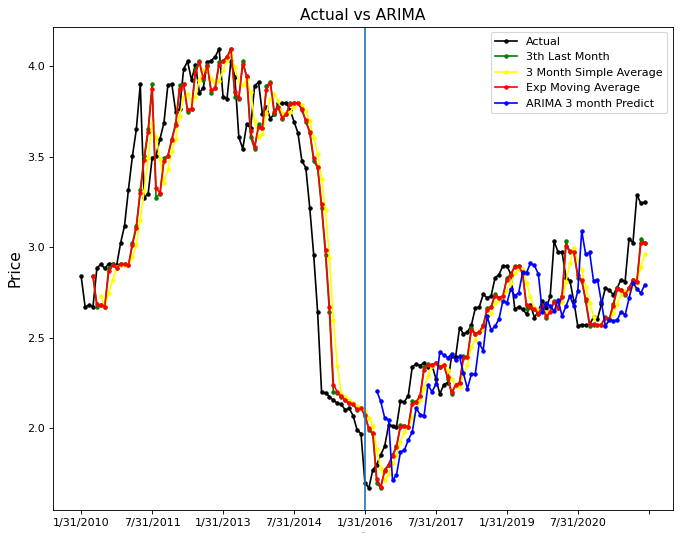

In [5]:
# Getting Model Outputs for Each Country
rmse, arima_order = evaluate_models(peru,[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],timeperiod = 3)
df = comparing_model(peru)
df.to_csv('Model Results/Peru_ARIMA and Moving Average Output.csv')

Best ARIMA (0, 0, 4) RMSE=0.404
Best ARIMA R2 is  -0.039015073660966015
Predicted Results
Error Using Arima Model 0.404
Error by Predicting price using just 3th Last Month Price. 0.331
Error by Predicting price using just 3th, 4th, 5th Last Month Price. 0.357
Error by Predicting price using Exponintial Average. 0.332


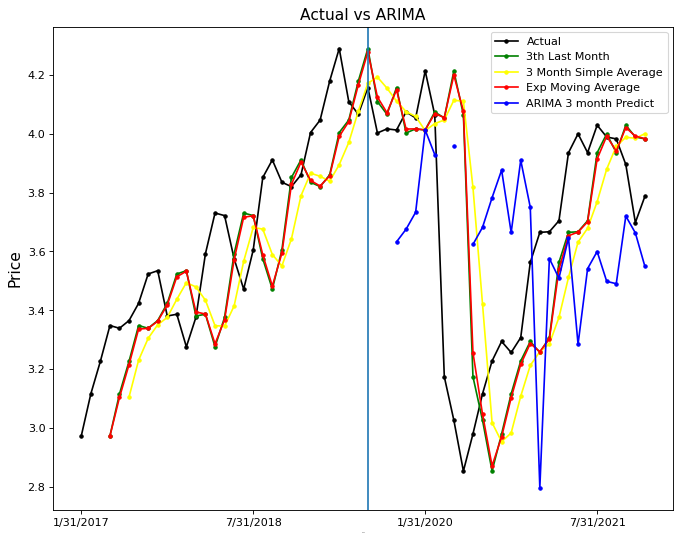

In [6]:
rmse, arima_order = evaluate_models(mexico,[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],timeperiod = 6)
df = comparing_model(mexico)
df.to_csv('Model Results/Mexico_ARIMA and Moving Average Output.csv')

Best ARIMA (6, 1, 6) RMSE=0.181
Best ARIMA R2 is  0.4567367727714283
Predicted Results
Error Using Arima Model 0.181
Error by Predicting price using just 3th Last Month Price. 0.187
Error by Predicting price using just 3th, 4th, 5th Last Month Price. 0.194
Error by Predicting price using Exponintial Average. 0.186


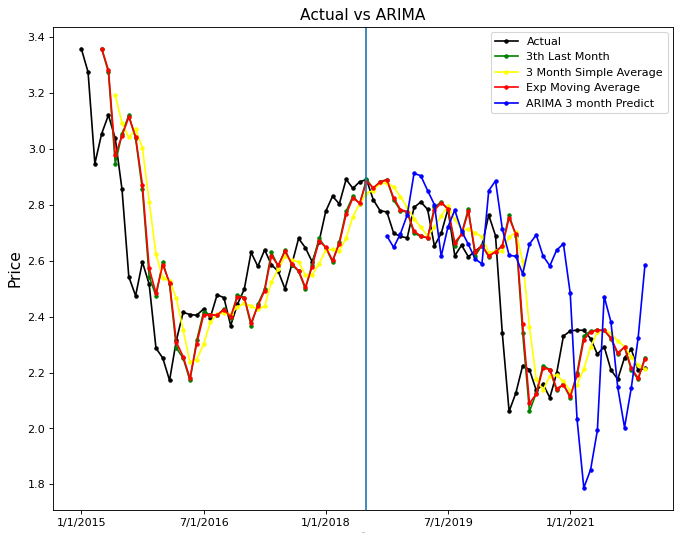

In [7]:
rmse, arima_order = evaluate_models(columbia,[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],timeperiod = 6)
df = comparing_model(columbia)
df.to_csv('Model Results/Columbia_ARIMA and Moving Average Output.csv')

Best ARIMA (1, 0, 0) RMSE=0.313
Best ARIMA R2 is  0.06206058615335153
Predicted Results
Error Using Arima Model 0.313
Error by Predicting price using just 3th Last Month Price. 0.247
Error by Predicting price using just 3th, 4th, 5th Last Month Price. 0.268
Error by Predicting price using Exponintial Average. 0.247


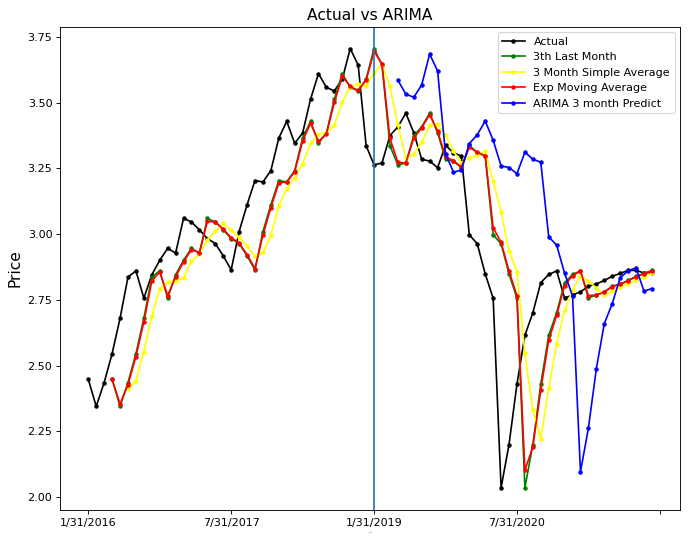

In [8]:
rmse, arima_order = evaluate_models(honduras,[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],timeperiod = 6)
df = comparing_model(honduras)
df.to_csv('Model Results/Honduras_ARIMA and Moving Average Output.csv')

Best ARIMA (2, 0, 4) RMSE=0.420
Best ARIMA R2 is  -0.21280556023010155
Predicted Results
Error Using Arima Model 0.42
Error by Predicting price using just 3th Last Month Price. 0.297
Error by Predicting price using just 3th, 4th, 5th Last Month Price. 0.346
Error by Predicting price using Exponintial Average. 0.3


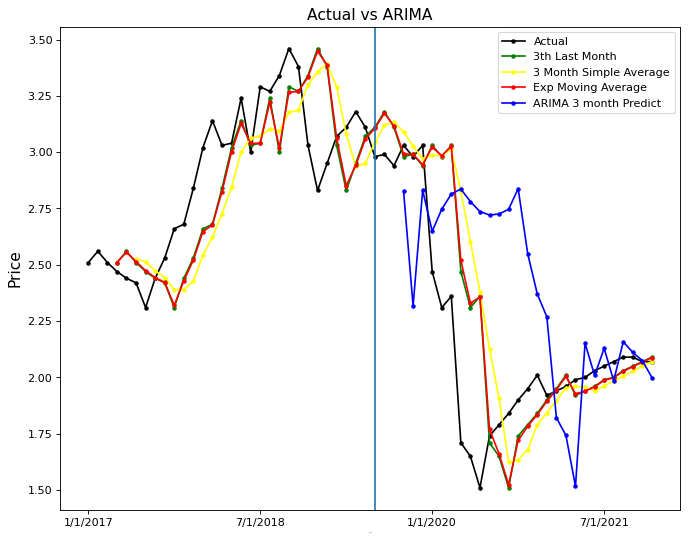

In [5]:
rmse, arima_order = evaluate_models(elsalvador,[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],timeperiod = 6)
df = comparing_model(elsalvador)
df.to_csv('Model Results/ElSalvador_ARIMA and Moving Average Output.csv')

Best ARIMA (1, 0, 0) RMSE=0.443
Best ARIMA R2 is  -0.26754401801174854
Predicted Results
Error Using Arima Model 0.443
Error by Predicting price using just 3th Last Month Price. 0.337
Error by Predicting price using just 3th, 4th, 5th Last Month Price. 0.355
Error by Predicting price using Exponintial Average. 0.336


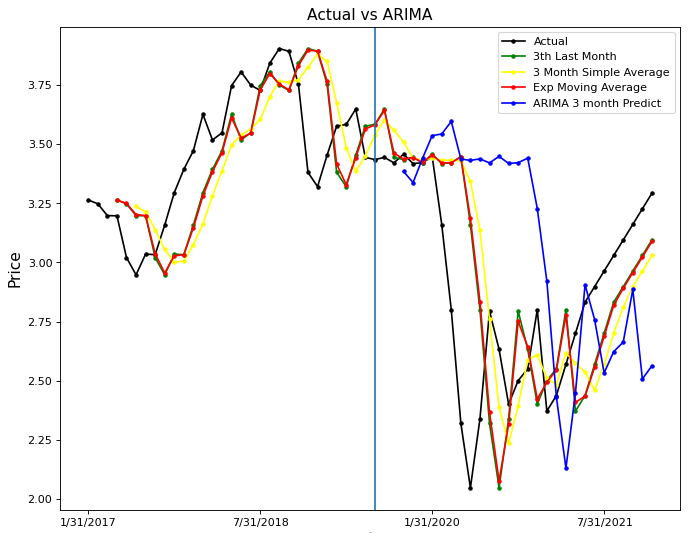

In [10]:
rmse, arima_order = evaluate_models(dominican,[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],[0,1,2,3,4,5,6],timeperiod = 6)
df = comparing_model(dominican)
df.to_csv('Model Results/DominicanRepublic_ARIMA and Moving Average Output.csv')

### Getting R2 Scores

In [6]:
# Loading Model Output Files

peru_2 = pd.read_csv('Model Results/Peru_ARIMA and Moving Average Output.csv')
mexico_2 = pd.read_csv('Model Results/Mexico_ARIMA and Moving Average Output.csv')
colombia_2 = pd.read_csv('Model Results/Columbia_ARIMA and Moving Average Output.csv')
dominican_2 = pd.read_csv('Model Results/DominicanRepublic_ARIMA and Moving Average Output.csv')
Honduras_2 = pd.read_csv('Model Results/Honduras_ARIMA and Moving Average Output.csv')
elsalvador_2 = pd.read_csv('Model Results/ElSalvador_ARIMA and Moving Average Output.csv')

In [7]:
# Function to get R2 Values with Prediction Timeframe

df = pd.DataFrame(columns = ['1_month', '2_month', '3_month',
       '4_month', '5_month', '6_month',
       '7_month', '8_month', '9_month',
       '10_month', '11_month', '12_month'], 
                 index = ['peru','colombia','mexico','dominican','honduras','elsalvador']).fillna(0.0)


def get_r2(dataset,country):
    
    dataset['moved1'] = dataset['Price USD'].shift(-1)
    dataset['moved2'] = dataset['Price USD'].shift(-2)
    dataset['moved3'] = dataset['Price USD'].shift(-3)
    dataset['moved4'] = dataset['Price USD'].shift(-4)
    dataset['moved5'] = dataset['Price USD'].shift(-5)
    dataset['moved6'] = dataset['Price USD'].shift(-6)
    dataset['moved7'] = dataset['Price USD'].shift(-7)
    dataset['moved8'] = dataset['Price USD'].shift(-8)
    dataset['moved9'] = dataset['Price USD'].shift(-9)
    dataset['moved10'] = dataset['Price USD'].shift(-10)
    dataset['moved11'] = dataset['Price USD'].shift(-11)
    dataset['moved12'] = dataset['Price USD'].shift(-12)
    
    xxx = dataset[['moved1','1_month_predict']].dropna()
    df.loc[country,'1_month'] = r2_score(xxx['moved1'],xxx['1_month_predict'])

    xxx = dataset[['moved2','2_month_predict']].dropna()
    df.loc[country,'2_month'] = r2_score(xxx['moved2'],xxx['2_month_predict'])

    xxx = dataset[['moved3','3_month_predict']].dropna()
    df.loc[country,'3_month'] = r2_score(xxx['moved3'],xxx['3_month_predict'])

    xxx = dataset[['moved4','4_month_predict']].dropna()
    df.loc[country,'4_month'] = r2_score(xxx['moved4'],xxx['4_month_predict'])

    xxx = dataset[['moved5','5_month_predict']].dropna()
    df.loc[country,'5_month'] = r2_score(xxx['moved5'],xxx['5_month_predict'])

    xxx = dataset[['moved6','6_month_predict']].dropna()
    df.loc[country,'6_month'] = r2_score(xxx['moved6'],xxx['6_month_predict'])

    xxx = dataset[['moved7','7_month_predict']].dropna()
    df.loc[country,'7_month'] = r2_score(xxx['moved7'],xxx['7_month_predict'])

    xxx = dataset[['moved8','8_month_predict']].dropna()
    df.loc[country,'8_month'] = r2_score(xxx['moved8'],xxx['8_month_predict'])

    xxx = dataset[['moved9','9_month_predict']].dropna()
    df.loc[country,'9_month'] = r2_score(xxx['moved9'],xxx['9_month_predict'])

    xxx = dataset[['moved10','10_month_predict']].dropna()
    df.loc[country,'10_month'] = r2_score(xxx['moved10'],xxx['10_month_predict'])

    xxx = dataset[['moved11','11_month_predict']].dropna()
    df.loc[country,'11_month'] = r2_score(xxx['moved11'],xxx['11_month_predict'])

    xxx = dataset[['moved12','12_month_predict']].dropna()
    df.loc[country,'12_month'] = r2_score(xxx['moved12'],xxx['12_month_predict'])
    
    return df
    

In [8]:
# Getting output for Each Country

get_r2(peru_2,'peru')
get_r2(colombia_2,'colombia')
get_r2(mexico_2,'mexico')
get_r2(dominican_2,'dominican')
get_r2(Honduras_2,'honduras')
get_r2(elsalvador_2,'elsalvador')

,1_month,2_month,3_month,4_month,5_month,6_month,7_month,8_month,9_month,10_month,11_month,12_month
peru,0.697088,0.615403,0.508639,0.398288,0.308382,0.258993,0.198534,0.110839,0.095069,0.062307,0.025198,0.070154
colombia,0.630424,0.388686,0.165320,-0.041504,-0.267340,-0.538341,-0.897744,-1.274459,-1.640323,-2.055680,-2.238358,-2.525979
mexico,0.358400,0.002272,-0.109500,-0.193065,-0.256100,-0.280142,-0.260469,-0.164831,-0.146595,-0.154265,-0.254029,-0.389523
dominican,0.325858,-0.030287,-0.249063,-0.568410,-1.081287,-1.670339,-2.380747,-2.852846,-3.099749,-3.263926,-3.771574,-3.959621
honduras,0.539424,0.276390,0.056342,-0.273218,-0.580380,-0.863937,-1.049115,-1.317977,-1.620863,-2.194070,-2.990666,-4.085283
elsalvador,-0.876530,-1.096520,-1.413017,-2.130035,-3.207075,-7.062080,-9.992565,-12.225722,-18.278190,-19.065554,-22.247594,-43.794358


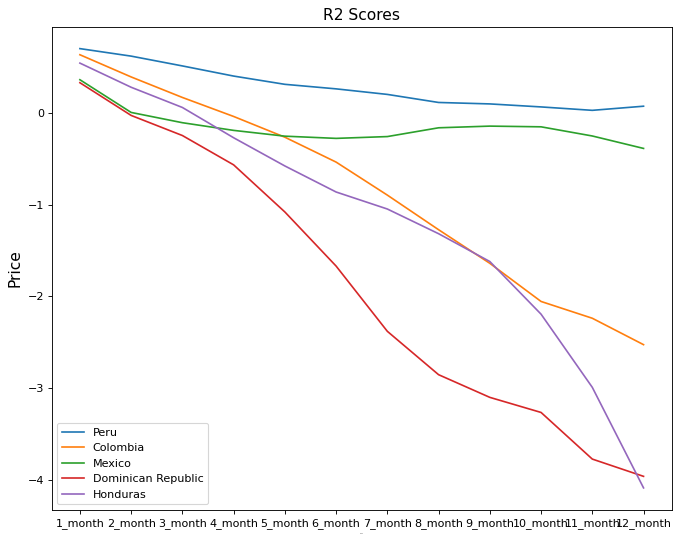

In [9]:
# Saving R2 scores to csv
df.to_csv('Model Results/All Country R2 Score.csv')

# Plotting R2 Graphs

df = df.transpose()
df.head()

figure(figsize=(10, 8), dpi=80)
plt.plot(df.index.values,df['peru'], label = 'Peru')
plt.plot(df.index.values,df['colombia'], label = 'Colombia')
plt.plot(df.index.values,df['mexico'], label = 'Mexico')
plt.plot(df.index.values,df['dominican'], label = 'Dominican Republic')
plt.plot(df.index.values,df['honduras'], label = 'Honduras')
# plt.plot(df.index.values,df['elsalvador'], label = 'El Salvador')
plt.title('R2 Scores', fontsize=14)
plt.xlabel('Year', fontsize=1)
plt.ylabel('Price', fontsize=14)
plt.legend()
plt.show()